In [ ]:
# Import the necessary library
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, functions as F, types as T
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

In [ ]:
# Configure the SparkSession to use the local master
spark = (
    SparkSession.builder
        .appName("Instacart-Merge")
        .master("local[*]")
        .config("spark.driver.bindAddress", "127.0.0.1")
        .config("spark.ui.port", "4041")
        .getOrCreate()
)

In [ ]:
# Load the dataset (header + schema inference)

df = (
    spark.read
         .option("header", True)
         .option("inferSchema", True)
         .csv("instacart_sample_2_5m.csv")
)

In [ ]:
# ─────────────────────────────────────────────────────────────
#Schema + basic counts
# ─────────────────────────────────────────────────────────────
df.printSchema()
total_rows = df.count()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)



###Exploratory Data Analysis

In [ ]:
# ─────────────────────────────────────────────────────────────
# Top‑ordered products (line‑item frequency)
# ─────────────────────────────────────────────────────────────
top_products = (
    df.groupBy("product_name")
      .agg(F.count("*").alias("line_count"))
      .orderBy(F.desc("line_count"))
      .limit(20)
)
top_products.show(truncate=False)

+------------------------+----------+
|product_name            |line_count|
+------------------------+----------+
|Banana                  |36146     |
|Bag of Organic Bananas  |29229     |
|Organic Strawberries    |20340     |
|Organic Baby Spinach    |18527     |
|Organic Hass Avocado    |16233     |
|Organic Avocado         |13594     |
|Large Lemon             |11991     |
|Strawberries            |11116     |
|Limes                   |10793     |
|Organic Whole Milk      |10577     |
|Organic Raspberries     |10488     |
|Organic Yellow Onion    |8661      |
|Organic Garlic          |8355      |
|Organic Zucchini        |8058      |
|Organic Blueberries     |7779      |
|Cucumber Kirby          |7363      |
|Organic Fuji Apple      |6825      |
|Organic Lemon           |6710      |
|Apple Honeycrisp Organic|6545      |
|Organic Grape Tomatoes  |6519      |
+------------------------+----------+



In [ ]:
# ─────────────────────────────────────────────────────────────
# Reorder rate overall and by department
# ─────────────────────────────────────────────────────────────
overall_reorder_rate = df.select(F.avg("reordered").alias("reorder_rate"))
overall_reorder_rate.show()

reorder_by_dept = (
    df.groupBy("department")
      .agg(
          F.avg("reordered").alias("reorder_rate"),
          F.count("*").alias("line_count")
      )
      .orderBy(F.desc("reorder_rate"))
)
reorder_by_dept.show(truncate=False)

+------------+
|reorder_rate|
+------------+
|   0.5896084|
+------------+

+---------------+-------------------+----------+
|department     |reorder_rate       |line_count|
+---------------+-------------------+----------+
|dairy eggs     |0.6700841011137325 |415809    |
|beverages      |0.6538669655625555 |206984    |
|produce        |0.6500511261421361 |731524    |
|bakery         |0.6262550311822725 |90436     |
|deli           |0.6072669047912305 |81190     |
|pets           |0.5977463312368972 |7632      |
|bulk           |0.5782080485952923 |2634      |
|babies         |0.5750758185306678 |32314     |
|snacks         |0.5741005319531306 |222576    |
|alcohol        |0.573662412306652  |11831     |
|meat seafood   |0.5695843771142277 |54689     |
|breakfast      |0.5599853827882332 |54730     |
|frozen         |0.541387619251238  |173059    |
|dry goods pasta|0.4605722469194737 |67034     |
|canned goods   |0.4596014250452926 |82243     |
|other          |0.41386628935267067|2827 

In [ ]:
# ─────────────────────────────────────────────────────────────
#  Basket size distribution
# ─────────────────────────────────────────────────────────────
basket_sizes = (
    df.groupBy("order_id")
      .agg(F.count("*").alias("basket_size"))
)
basket_sizes.describe().show()

+-------+------------------+------------------+
|summary|          order_id|       basket_size|
+-------+------------------+------------------+
|  count|           1591177|           1591177|
|   mean|1711049.6007640886|1.5711639874130912|
| stddev| 987343.4843163106|0.9044335464184329|
|    min|                 1|                 1|
|    max|           3421078|                13|
+-------+------------------+------------------+



In [ ]:
# ─────────────────────────────────────────────────────────────
# Orders by day‑of‑week and hour‑of‑day
# ─────────────────────────────────────────────────────────────
orders_by_dow = (
    df.select("order_id", "order_dow")
      .distinct()
      .groupBy("order_dow")
      .agg(F.count("*").alias("num_orders"))
      .orderBy("order_dow")
)
orders_by_dow.show()

+---------+----------+
|order_dow|num_orders|
+---------+----------+
|        0|    299120|
|        1|    275634|
|        2|    209796|
|        3|    193014|
|        4|    189476|
|        5|    207281|
|        6|    216856|
+---------+----------+



In [ ]:
orders_by_hour = (
    df.select("order_id", "order_hour_of_day")
      .distinct()
      .groupBy("order_hour_of_day")
      .agg(F.count("*").alias("num_orders"))
      .orderBy("order_hour_of_day")
)
orders_by_hour.show()

+-----------------+----------+
|order_hour_of_day|num_orders|
+-----------------+----------+
|                0|     10595|
|                1|      5610|
|                2|      3426|
|                3|      2470|
|                4|      2558|
|                5|      4391|
|                6|     13998|
|                7|     43380|
|                8|     83407|
|                9|    119152|
|               10|    134095|
|               11|    132863|
|               12|    128247|
|               13|    130241|
|               14|    132121|
|               15|    131655|
|               16|    126157|
|               17|    104977|
|               18|     82781|
|               19|     63820|
+-----------------+----------+
only showing top 20 rows



In [ ]:
# ─────────────────────────────────────────────────────────────
#  Top aisle‑department combinations (line frequency)
# ─────────────────────────────────────────────────────────────
aisle_dept = (
    df.groupBy("department", "aisle")
      .agg(F.count("*").alias("line_count"))
      .orderBy(F.desc("line_count"))
      .limit(20)
)
aisle_dept.show(truncate=False)

+----------+-----------------------------+----------+
|department|aisle                        |line_count|
+----------+-----------------------------+----------+
|produce   |fresh fruits                 |280606    |
|produce   |fresh vegetables             |263599    |
|produce   |packaged vegetables fruits   |136659    |
|dairy eggs|yogurt                       |110955    |
|dairy eggs|packaged cheese              |75434     |
|dairy eggs|milk                         |68319     |
|beverages |water seltzer sparkling water|64921     |
|snacks    |chips pretzels               |55669     |
|dairy eggs|soy lactosefree              |49125     |
|bakery    |bread                        |45215     |
|beverages |refrigerated                 |44302     |
|frozen    |frozen produce               |40191     |
|frozen    |ice cream ice                |38809     |
|snacks    |crackers                     |35631     |
|snacks    |energy granola bars          |35008     |
|dairy eggs|eggs            

In [ ]:
# ------------------------------------------------------------
# Plotting setup (uses matplotlib; adjust style as desired)
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Top 10 departments by line‐item count
dept_counts = (df
    .groupBy("department")
    .agg(F.count("*").alias("line_count"))
    .orderBy(F.desc("line_count"))
    .limit(10))
dept_counts_pd = dept_counts.toPandas()

In [ ]:
# Reorder rate by day of week
reorder_by_dow = (df
    .groupBy("order_dow")
    .agg(F.avg("reordered").alias("reorder_rate"))
    .orderBy("order_dow"))
reorder_by_dow_pd = reorder_by_dow.toPandas()

In [ ]:
# Average basket size by day of week
# Merge basket_sizes with the original DataFrame (df) to get order_dow
avg_basket_by_dow = (
    basket_sizes.join(df.select("order_id", "order_dow"), "order_id", "left")  # Join on order_id
                 .groupBy("order_dow")
                 .agg(F.avg("basket_size").alias("avg_basket_size"))
                 .orderBy("order_dow")
)
avg_basket_by_dow_pd = avg_basket_by_dow.toPandas()

In [ ]:
# Days since prior order distribution
days_since_pd = (df
    .select("days_since_prior_order")
    .na.drop()
    .toPandas()
)


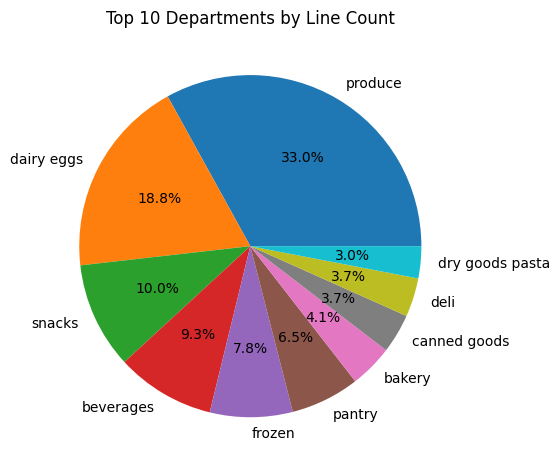

In [ ]:
# pie chart: Top 10 departments
plt.figure()
plt.pie(dept_counts_pd["line_count"], labels=dept_counts_pd["department"], autopct="%1.1f%%")
plt.title("Top 10 Departments by Line Count")
plt.tight_layout()


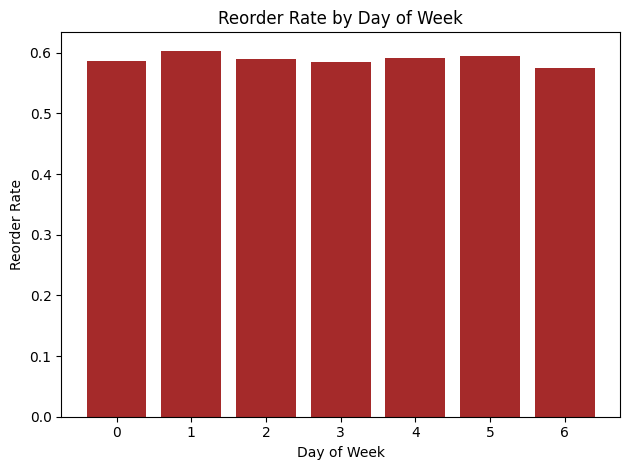

In [ ]:
#Bar chart: Reorder rate by day of week
plt.figure()
plt.bar(reorder_by_dow_pd["order_dow"], reorder_by_dow_pd["reorder_rate"], color = "brown")
plt.title("Reorder Rate by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Reorder Rate")
plt.tight_layout()
plt.show()

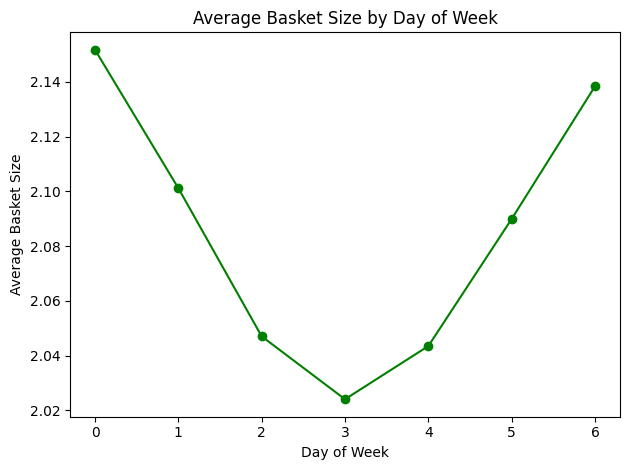

In [ ]:
#  Line plot: Average basket size by day of week
plt.figure()
plt.plot(
    avg_basket_by_dow_pd["order_dow"],
    avg_basket_by_dow_pd["avg_basket_size"],
    marker="o", color = "green"
)
plt.title("Average Basket Size by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Basket Size")
plt.tight_layout()
plt.show()

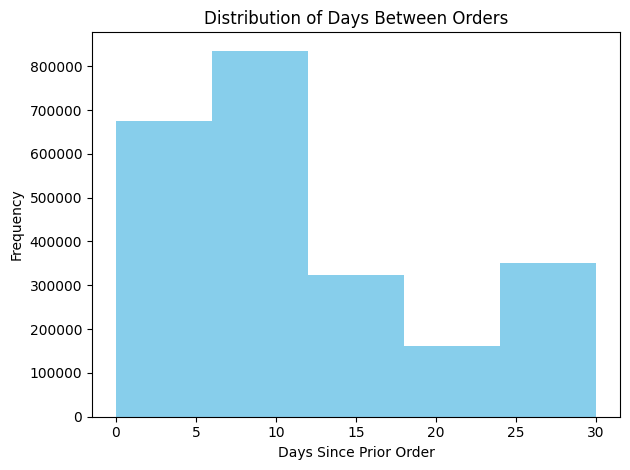

In [ ]:
# Histogram: Distribution of days between orders
plt.figure()
plt.hist(days_since_pd["days_since_prior_order"], bins=5, color = 'skyblue')
plt.title("Distribution of Days Between Orders")
plt.xlabel("Days Since Prior Order")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

###Data Preparation

In [ ]:
#Define the schema for the Instacart dataset (for better control of data types)
schema = StructType([
    StructField("order_id", IntegerType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("add_to_cart_order", IntegerType(), True),
    StructField("reordered", IntegerType(), True),
    StructField("product_name", StringType(), True),
    StructField("aisle_id", IntegerType(), True),
    StructField("department_id", IntegerType(), True),
    StructField("aisle", StringType(), True),
    StructField("department", StringType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("eval_set", StringType(), True),
    StructField("order_number", IntegerType(), True),
    StructField("order_dow", IntegerType(), True),
    StructField("order_hour_of_day", IntegerType(), True),
    StructField("days_since_prior_order", DoubleType(), True)  # use DoubleType to accommodate nulls
])

In [ ]:
# SFilter to include only 'prior' orders, which represent completed historical orders
df = df.filter(F.col("eval_set") == "prior")

In [ ]:
# # Drop irrelevant or redundant columns that won't be used in co-purchase analysis
# df = df.drop(
#     "add_to_cart_order",   # not needed for co-purchase frequency analysis
#     "reordered",           # not needed for item co-occurrence analysis
#     "product_name",        # product IDs suffice; drop name to reduce size
#     "aisle_id", "aisle",   # drop aisle info (focus on higher-level category or not needed)
#     "department",          # drop department name (keep numeric ID for category analysis)
#     "user_id",             # not needed for co-purchase patterns (we analyze per order, not per user here)
#     "eval_set",            # no longer needed after filtering to "prior"
#     "order_number",        # not needed for co-purchase analysis
#     "order_dow", "order_hour_of_day"  # not needed for this analysis
# )

In [ ]:
# Ensure correct data types after cleaning
# Cast 'days_since_prior_order' to integer now that nulls are handled (days are whole numbers).
df = df.withColumn("days_since_prior_order", F.col("days_since_prior_order").cast(IntegerType()))

In [ ]:
# count null (or NaN) values in every column of the DataFrame `master`
null_summary = df.select([
    F.sum(
        F.when(
            F.col(c).isNull() | F.isnan(c),   # handles both null and NaN
            1
        ).otherwise(0)
    ).alias(c)
    for c in df.columns
])

null_summary.show(truncate=False)

+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|product_name|aisle_id|department_id|aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+
|0       |0         |0                |0        |0           |0       |0            |0    |0         |0      |0       |0           |0        |0                |153477                |
+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+



In [ ]:
# drop every row containing at least one null (or NaN) value
df = df.na.drop()

In [ ]:
#Again check for null values
null_summary = df.select([
    F.sum(
        F.when(
            F.col(c).isNull() | F.isnan(c),   # handles both null and NaN
            1
        ).otherwise(0)
    ).alias(c)
    for c in df.columns
])

null_summary.show(truncate=False)

+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|product_name|aisle_id|department_id|aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+
|0       |0         |0                |0        |0           |0       |0            |0    |0         |0      |0       |0           |0        |0                |0                     |
+--------+----------+-----------------+---------+------------+--------+-------------+-----+----------+-------+--------+------------+---------+-----------------+----------------------+



In [ ]:
df.show(5, truncate=False)
print(("df rows", df.count()), ("columns", len(df.columns)))

+--------+----------+-----------------+---------+-----------------------------------+--------+-------------+--------------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|product_name                       |aisle_id|department_id|aisle                     |department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-----------------------------------+--------+-------------+--------------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|593759  |11068     |4                |1        |Medium Cheddar Cheese Block        |21      |16           |packaged cheese           |dairy eggs|51780  |prior   |68          |4        |12               |7                     |
|1214222 |10749     |8                |1        |Organic Red Bell Pepper            |83 

At this point, df contains the essential fields for analysis:
 - order_id, product_id, department_id, days_since_prior_order (with no missing values)

In [ ]:
#Prepare data for co-purchase analysis by aggregating items per order
# Group by order_id to collect all product IDs in each order and count the number of items
transactions_df = df.groupBy("order_id").agg(
    F.collect_set("product_id").alias("items"),             # list of unique products in the order
    F.count("*").alias("order_size"),                      # total number of items in the order
    F.first("days_since_prior_order").alias("days_since_prior_order")  # carry over order-level gap time
)

In [ ]:
transactions_df.show(5, truncate=False)
print(("df rows", transactions_df.count()), ("columns", len(transactions_df.columns)))

+--------+--------------+----------+----------------------+
|order_id|items         |order_size|days_since_prior_order|
+--------+--------------+----------+----------------------+
|31      |[21903]       |1         |14                    |
|78      |[21573]       |1         |15                    |
|81      |[39928, 44683]|2         |9                     |
|108     |[5212]        |1         |1                     |
|115     |[48657]       |1         |8                     |
+--------+--------------+----------+----------------------+
only showing top 5 rows

('df rows', 1429927) ('columns', 4)


In [ ]:
#Differentiate between small and large orders (e.g., using a threshold of 10 items)
transactions_df = transactions_df.withColumn(
    "order_type",
    F.when(F.col("order_size") < 10, "Small").otherwise("Large")
)

In [ ]:
# View top 10 rows of the cleaned and prepared dataset
transactions_df.show(10, truncate=False)


+--------+--------------+----------+----------------------+----------+
|order_id|items         |order_size|days_since_prior_order|order_type|
+--------+--------------+----------+----------------------+----------+
|31      |[21903]       |1         |14                    |Small     |
|78      |[21573]       |1         |15                    |Small     |
|81      |[39928, 44683]|2         |9                     |Small     |
|108     |[5212]        |1         |1                     |Small     |
|115     |[48657]       |1         |8                     |Small     |
|183     |[4305]        |1         |4                     |Small     |
|193     |[29594, 49075]|2         |7                     |Small     |
|243     |[45200]       |1         |30                    |Small     |
|255     |[47049]       |1         |3                     |Small     |
|321     |[21497]       |1         |17                    |Small     |
+--------+--------------+----------+----------------------+----------+
only s

In [ ]:
# Print the schema to verify data types
transactions_df.printSchema()


root
 |-- order_id: integer (nullable = true)
 |-- items: array (nullable = false)
 |    |-- element: integer (containsNull = false)
 |-- order_size: long (nullable = false)
 |-- days_since_prior_order: integer (nullable = true)
 |-- order_type: string (nullable = false)



Now `transactions_df` is the cleaned and prepared dataset:
- order_id: unique order identifier
- items: array of product IDs in that order (ready for FPGrowth or co-purchase mining)
- order_size: total count of items in the order (for small vs. large order analysis)
- days_since_prior_order: days since last order (0 if no prior order)
- order_type: label indicating a "Small" or "Large" order based on the chosen threshold
(The cleaned data can now be used for frequent itemset mining, co-purchase pattern analysis.across categories by joining product_id with department_id if needed, and comparing small vs large orders.)